# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [1]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [2]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    # TODO: compute the values of prior for each class!
    # ==========================
    #divide points in classes
    llc = []
    wlc = []
    Wk = np.zeros((Nclasses,1))
    for jdx,label in enumerate(classes):
        idx = np.where(labels==label)[0]
        llc.append(labels[idx])
        wlc.append(W[idx])
    for k in range(Nclasses):
        for i in range(int(len(llc[k]))):
            Wk[k][0] += wlc[k][i]
        prior[k][0] = Wk[k][0]
    # ==========================

    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W):
    assert(X.shape[0]==labels.shape[0]) #check if same length basicly
    Npts,Ndims = np.shape(X) 
    classes = np.unique(labels)
    Nclasses = np.size(classes)
    
    #N =200, C=5, d=2

    #weight is equal for all, 1/200 (1/ amount of points)
    if W is None:
        W = np.ones((Npts,1))/float(Npts)
        

    mu = np.zeros((Nclasses,Ndims)) #C x 2 matrix (2D)
    sigma = np.zeros((Nclasses,Ndims,Ndims)) #C x 2 x 2 matrix (3D)

    # TODO: fill in the code to compute mu and sigma!
    # ==========================  
    #divide points in classes
    xlc = []
    wlc = []
    for jdx,label in enumerate(classes):
        idx = np.where(labels==label)[0]
        xlc.append(X[idx,:])
        wlc.append(W[idx])
    
    #compute mu (and Nk)
    Wk = np.zeros((Nclasses,1))
    for k in range(Nclasses):
        for i in range(int(len(xlc[k]))):
            for j in range(Ndims):
                mu[k][j] += wlc[k][i]*xlc[k][i][j]
            Wk[k][0] += wlc[k][i]
        for j in range(Ndims):
            mu[k][j] = mu[k][j] / Wk[k][0]
   

    #print("NK: ",Nk)
    #print("mu: ",mu)
    
    #compute sigma
    for k in range(Nclasses):
        for m in range(Ndims):
            for n in range(Ndims):
                if m == n:
                    for i in range(int(len(xlc[k]))):
                        sigma[k][m][n] += wlc[k][i]*((xlc[k][i][m]-mu[k][m])**2)
                    sigma[k][m][n] = sigma[k][m][n] / Wk[k][0]
                else:
                    sigma[k][m][n] = 0
    #print("sigma: ",sigma)
    
    
    #compute mu (and Nk)
#    Nk = np.zeros(Nclasses)
#    for k in range(Nclasses):
#        Nk[k] = len(xlc[k])
#        for i in range(int(Nk[k])):
#            for j in range(Ndims):
#                mu[k][j] += xlc[k][i][j]
#            
#        for j in range(Ndims):
#            mu[k][j] = mu[k][j] / Nk[k]
#   

#    print("NK: ",Nk)
#    print("mu: ",mu)
#    
#    #compute sigma
#    for k in range(Nclasses):
#        for m in range(Ndims):
#            for n in range(Ndims):
#                if m == n:
#                    for i in range(int(Nk[k])):
#                        sigma[k][m][n] += (xlc[k][i][m]-mu[k][m])**2
#                    sigma[k][m][n] = sigma[k][m][n] / Nk[k]
#                else:
#                    sigma[k][m][n] = 0
#    print("sigma: ",sigma)
    
    # ==========================

    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))
    term = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    for k in range(Nclasses):
        for i in range(Npts):
            for j in range(Ndims):
                 term[k][i] += ((X[i][j] - mu[k][j])**2)/sigma[k][j][j]
            logProb[k][i] = -1/2*np.log(np.linalg.det(sigma[k])) - 1/2*term[k][i] + np.log(prior[k])
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [3]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

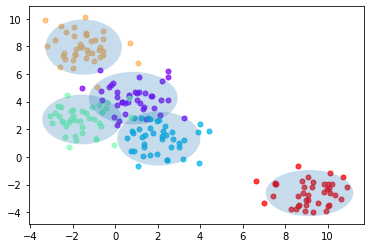

In [4]:
%matplotlib inline

W = None
X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels,W)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [5]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [6]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

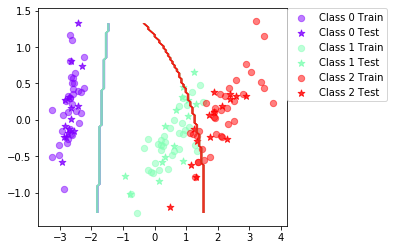

In [7]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Questions:

#### 1) When can a feature independence assumption be reasonable and when not?

Use common sense, for example cloudyness and temperature will not be independent.

#### 2) How does the decision boundary look for the Iris dataset? How could one improve the classification results for this scenario by changing classifier or, alternatively, manipulating the data?

It looks good between class 0 and class 1, but not so great between class 1 and 2. The problem is that a few points that are gotten wrong on every iteration never have enough weight compared to the points that are already correct to pull the boundary line towards them. Giving these points more weight could pull the boundary towards them and result in a better classifier.

If by manipulating the data it is litteraly implied we could change the values of the features then a good way to improve the classifier is if each class has a feature where it is different from all the others, (e.g. class 0 has an x <=-2 for all its points, class 1 and 2 have overlap on both the x and y dimension)

Also if the point distribution is too complex it might be better to use an rbf svm for example to draw more complex decision boundaries.

## Boosting functions to implement

The lab descriptions state what each function should do.

In [8]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)
        
        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        error = 0
        for i in range(Npts):
            error += wCur[i][0]*(1 - int(vote[i] == labels[i]))
        
        alpha = 1/2*(np.log(1-error)-np.log(error))
        
        neW = np.zeros((Npts,1))
        Z = 0
        for i in range(Npts):
            if vote[i] == labels[i]:
                neW[i][0] = wCur[i][0] * np.exp(-alpha)
            else:
                neW[i][0] = wCur[i][0] * np.exp(alpha)
            Z += neW[i][0]
        
        wCur = neW/Z
        
        alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)
    
    #print("Ncomps: ",Ncomps)
    #print("Nclasses: ",Nclasses)
    
    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        compVotes = np.zeros((Ncomps,Npts))
        for t in range(Ncomps):
            compVotes[t] = classifiers[t].classify(X)
        
        for i in range(Npts):
            for t in range(Ncomps):
                votes[i][int(compVotes[t][i])] += alphas[t] #*δ(h(x),ci)?
            
        # ==========================
        
        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [9]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [10]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6


C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sdelo\AppData\Roaming\Python\Python37\site-packages\numpy\linalg\linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.1 with standard deviation 6.72


In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

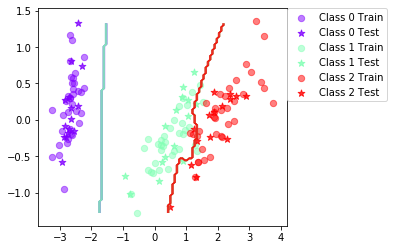

In [12]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

## Questions:

### For the Bayes classifier:

#### 1) Is there any improvement in classification accuracy? Why/why not?

| type | classification accuracy | standard deviation |
| --- | --- | --- |
| iris Normal (T=1)   | 89 | 4.16 |
| iris Boosted (T=10) | __94.1__ | 6.72 |
| vowel Normal (T=1)  | 64.7 | 4.03 |
| vowel Boosted (T=10)| __80.2__ | 3.52 |

Yes, there is definitely an improvement in classification accuracy. Before boosting, a certain amount of points could be on the wrong side of the boundary everytime because they dont weigh on the decision of where to draw the boundary enough. Increasing the weight of those points that get wrongly classified and decreasing the weight of points that are already correct will result in a more different boundary next time that incorporates these previously wrong points. Doing this on every iteration and keeping track of which seperations performed best and giving them weight accordingly will result in a better and more defined final boundary.


#### 2) Plot the decision boundary of the boosted classifier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

The line seperates class 1 and 2 way better than before the boosting. Before the boosting the line was a simple curve, now we notice a more complex line, that can curve around data points. This is because it is the combination of multiple more different lines. This tells us boosting can be a good way to reduce bias, because it allows for more complex boundaries.

#### 3) Can we make up for not using a more advanced model in the basic classifier (e.g. independent features) by using boosting?

To a certain extend, yes, because we can draw more complex lines using boosting. Howerver, if a really complex line is required, it is definetly more optimal to use a model that can deal with that easier (for example an SVM with an RBF kernel.

## Now repeat the steps with a decision tree classifier.

In [13]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [14]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [15]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [16]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 85.7
Trial: 10 Accuracy 90.3
Trial: 20 Accuracy 88.3
Trial: 30 Accuracy 90.9
Trial: 40 Accuracy 84.4
Trial: 50 Accuracy 81.2
Trial: 60 Accuracy 87.7
Trial: 70 Accuracy 86.4
Trial: 80 Accuracy 87
Trial: 90 Accuracy 90.3
Final mean classification accuracy  86.8 with standard deviation 2.71


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

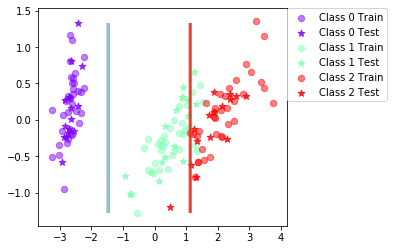

In [17]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

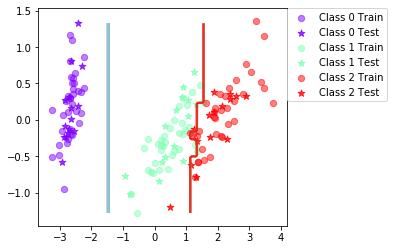

In [18]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Questions:

### For the DecisionTreeClassifier:

#### 1) Is there any improvement in classification accuracy? Why/why not?

| type | classification accuracy | standard deviation |
| --- | --- | --- |
| iris Normal (T=1)   | 92.4 | 3.71 |
| iris Boosted (T=10) | __94.6__ | 3.65 |
| vowel Normal (T=1)  | 64.1 | 4 |
| vowel Boosted (T=10)| __86.8__ | 2.71 |

Yes, again there is an improvement, same reason as for bayes. (a decision tree model will draw a straight line seperating the classes. Using boosting it will next time draw it a little more different to get the points it got wrong before on the right side this time. The combination of these lines will result in a slighty better and more complex line)


#### 2) Plot the decision boundary of the boosted classifier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

The boundary is more complex, but not THAT much more complex. This is because the model is a decision tree, decision trees are only capable of drawing straight lines.

#### 3) Can we make up for not using a more advanced model in the basic classifier (e.g. independent features) by using boosting?

In a situation where very complex boundaries are needed, opting for a more advanced model would be preferable compared to boosting a decision tree.

## Questions:

### If you had to pick a classifier, naive Bayes or a decision tree or the boosted versions of these, which one would you pick? Motivate from the following criteria:
 
 
 
 - __Outliers:__
 
     Decision trees have high variance and low bias, making them good at modeling outliers by default. Naive Bayes would need boosting to model outliers. Boosting helps reduce bias even further, so the optimal choice would be boosted decision tree.
 

 - __Irrelevant inputs: part of the feature space is irrelevant:__

    Decision tree's dont take irrelevant parts into consideration, so they handle it very well. If the probability for irrelevant features isn't uniform then it will impact the classification of Naive Bayes.
        
        
 - __Predictive power:__ 

    As seen before, the boosted versions have more predictive power.
    Bayes has more bias, Decision trees have more variance, so there's a danger of overfitting. The predictive power of either or depends on the given data.
    
    
 - __Mixed types of data: binary, categorical or continuous features, etc.:__
     
   Both can handle mixed types of data, but a DT has to make continuous features discrete, by drawing boundaries, and thus turning them into categorical features. 
   Naive Bayes can use a guassian model, like the one we used here, to handle continuous features. 
   Binary data can be regarded as catergorical data.
   
   If we have a mixed dataset, we obviously can't use gaussian NB for all of the data. We would have to either use standard NB and make the continuous data discrete (categorical) by seperating the values into groups, OR make a seperate model for the catergorical data and for the continuous data, and then use the probabilities we got from both to make a new (Guassian) model.   
 - __Scalability: the dimension of the data, D, is large or the number of instances, N, is large, or both.:__ 

    Bayes performs well with high dimensions and low number of instances. This because it assumes feature independence, so each distribution can be looked at in 1 dimension. This helps to handle the curse of dimensionality.
    Decision trees don't perform well with high dimensions, they overfit on the abundant attributes. 
    
    When it comes to scalability, boosting will get very computationally extensive because it needs to calculate weight for each seperate instance.
    

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [113]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


In [117]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sdelo\AppData\Roaming\Python\Python37\site-packages\numpy\linalg\linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Trial: 0 Accuracy 2.5


C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sdelo\AppData\Roaming\Python\Python37\site-packages\numpy\linalg\linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\sdelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sdelo\AppData\Roaming\Python\Python37\site-packages\numpy\linalg\linalg.py:2125: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


KeyboardInterrupt: 

In [118]:
testClassifier(DecisionTreeClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 65.8
Trial: 10 Accuracy 57.5
Trial: 20 Accuracy 49.2
Trial: 30 Accuracy 50
Trial: 40 Accuracy 53.3
Trial: 50 Accuracy 44.2
Trial: 60 Accuracy 49.2
Trial: 70 Accuracy 54.2
Trial: 80 Accuracy 50
Trial: 90 Accuracy 52.5
Final mean classification accuracy  48.4 with standard deviation 6.45


In [114]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 74.2
Trial: 10 Accuracy 68.3
Trial: 20 Accuracy 75
Trial: 30 Accuracy 72.5
Trial: 40 Accuracy 71.7
Trial: 50 Accuracy 65.8
Trial: 60 Accuracy 75
Trial: 70 Accuracy 51.7
Trial: 80 Accuracy 70.8
Trial: 90 Accuracy 75.8
Final mean classification accuracy  70.6 with standard deviation 6.14


You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

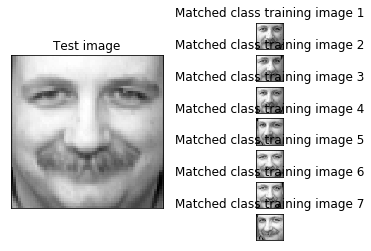

In [116]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])